<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 24: Autoencoders
### Notebook 2: Autoencoders and MNIST

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
# Some code inspired or based on:
#    https://blog.keras.io/building-autoencoders-in-keras.html
#    https://jmetzen.github.io/2015-11-27/vae.html
#    https://arxiv.org/pdf/1606.05908.pdf  (https://github.com/cdoersch/vae_tutorial)
#

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
random_seed = 42
np.random.seed(random_seed)

# Read MNIST data. We won't be using the y_train or y_test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
pixels_per_image = np.prod(X_train.shape[1:])

# Cast values into the current floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), pixels_per_image))
X_test = X_test.reshape((len(X_test), pixels_per_image))

print("X_train.shape = ",X_train.shape, " X_test.shape = ",X_test.shape)

X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [5]:
def draw_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

In [6]:
# Build and train our first autoencoder
num_latent_vars = 20

AE1 = Sequential()
AE1.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE1.add(Dense(pixels_per_image, activation='sigmoid'))
AE1.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE1-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE1, weights_filename):
    AE1.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE1, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 3s - loss: 0.3230 - val_loss: 0.2593
Epoch 2/50
 - 2s - loss: 0.2399 - val_loss: 0.2200
Epoch 3/50
 - 3s - loss: 0.2095 - val_loss: 0.1976
Epoch 4/50
 - 2s - loss: 0.1913 - val_loss: 0.1832
Epoch 5/50
 - 3s - loss: 0.1795 - val_loss: 0.1735
Epoch 6/50
 - 3s - loss: 0.1707 - val_loss: 0.1654
Epoch 7/50
 - 3s - loss: 0.1632 - val_loss: 0.1586
Epoch 8/50
 - 2s - loss: 0.1568 - val_loss: 0.1528
Epoch 9/50
 - 2s - loss: 0.1514 - val_loss: 0.1480
Epoch 10/50
 - 2s - loss: 0.1469 - val_loss: 0.1435
Epoch 11/50
 - 2s - loss: 0.1429 - val_loss: 0.1398
Epoch 12/50
 - 2s - loss: 0.1395 - val_loss: 0.1365
Epoch 13/50
 - 2s - loss: 0.1365 - val_loss: 0.1336
Epoch 14/50
 - 3s - loss: 0.1338 - val_loss: 0.1310
Epoch 15/50
 - 2s - loss: 0.1315 - val_loss: 0.1288
Epoch 16/50
 - 2s - loss: 0.1295 - val_loss: 0.1269
Epoch 17/50
 - 2s - loss: 0.1277 - val_loss: 0.1253
Epoch 18/50
 - 2s - loss: 0.1263 - val_loss: 0.1240
Epoch 19/50
 - 2s - los

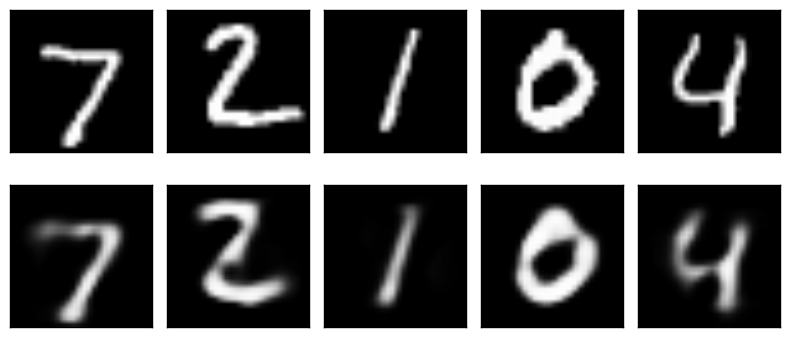

In [7]:
predictions1 = AE1.predict(X_test)
draw_predictions_set(predictions1, 'NB2-MLP-AE1')

In [8]:
# Build and train our second, more compress-y autoencoder
num_latent_vars = 10

AE2 = Sequential()
AE2.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE2.add(Dense(pixels_per_image, activation='sigmoid'))
AE2.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE2-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE2, weights_filename):
    AE2.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE2, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 3s - loss: 0.3338 - val_loss: 0.2673
Epoch 2/50
 - 2s - loss: 0.2556 - val_loss: 0.2392
Epoch 3/50
 - 2s - loss: 0.2270 - val_loss: 0.2142
Epoch 4/50
 - 2s - loss: 0.2078 - val_loss: 0.1994
Epoch 5/50
 - 2s - loss: 0.1963 - val_loss: 0.1910
Epoch 6/50
 - 2s - loss: 0.1898 - val_loss: 0.1859
Epoch 7/50
 - 2s - loss: 0.1854 - val_loss: 0.1823
Epoch 8/50
 - 2s - loss: 0.1824 - val_loss: 0.1797
Epoch 9/50
 - 2s - loss: 0.1802 - val_loss: 0.1780
Epoch 10/50
 - 2s - loss: 0.1786 - val_loss: 0.1764
Epoch 11/50
 - 2s - loss: 0.1773 - val_loss: 0.1752
Epoch 12/50
 - 2s - loss: 0.1762 - val_loss: 0.1742
Epoch 13/50
 - 2s - loss: 0.1751 - val_loss: 0.1732
Epoch 14/50
 - 2s - loss: 0.1742 - val_loss: 0.1722
Epoch 15/50
 - 2s - loss: 0.1733 - val_loss: 0.1713
Epoch 16/50
 - 2s - loss: 0.1725 - val_loss: 0.1705
Epoch 17/50
 - 2s - loss: 0.1717 - val_loss: 0.1698
Epoch 18/50
 - 2s - loss: 0.1710 - val_loss: 0.1691
Epoch 19/50
 - 2s - los

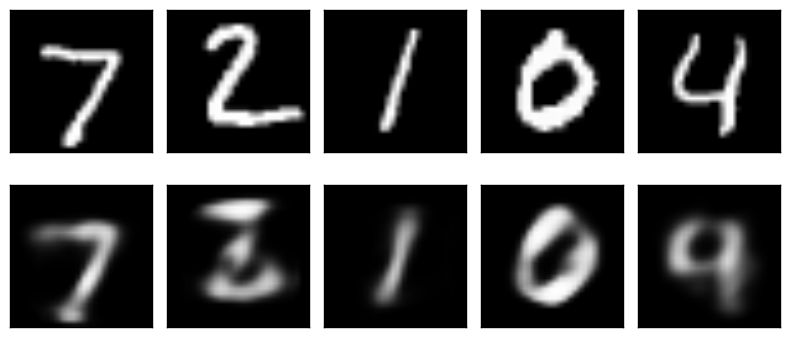

In [9]:
predictions2 = AE2.predict(X_test)
draw_predictions_set(predictions2, 'NB2-MLP-AE2')

In [10]:
# Build and train our third, super compress-y autoencoder
num_latent_vars = 3

AE3 = Sequential()
AE3.add(Dense(num_latent_vars, input_dim=pixels_per_image, activation='relu'))
AE3.add(Dense(pixels_per_image, activation='sigmoid'))
AE3.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE3-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE3, weights_filename):
    AE3.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE3, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 3s - loss: 0.3341 - val_loss: 0.2701
Epoch 2/50
 - 2s - loss: 0.2646 - val_loss: 0.2574
Epoch 3/50
 - 2s - loss: 0.2554 - val_loss: 0.2527
Epoch 4/50
 - 2s - loss: 0.2527 - val_loss: 0.2508
Epoch 5/50
 - 2s - loss: 0.2506 - val_loss: 0.2472
Epoch 6/50
 - 2s - loss: 0.2425 - val_loss: 0.2365
Epoch 7/50
 - 2s - loss: 0.2367 - val_loss: 0.2340
Epoch 8/50
 - 2s - loss: 0.2348 - val_loss: 0.2325
Epoch 9/50
 - 2s - loss: 0.2335 - val_loss: 0.2315
Epoch 10/50
 - 2s - loss: 0.2324 - val_loss: 0.2303
Epoch 11/50
 - 2s - loss: 0.2315 - val_loss: 0.2293
Epoch 12/50
 - 2s - loss: 0.2306 - val_loss: 0.2287
Epoch 13/50
 - 2s - loss: 0.2299 - val_loss: 0.2278
Epoch 14/50
 - 2s - loss: 0.2291 - val_loss: 0.2271
Epoch 15/50
 - 2s - loss: 0.2285 - val_loss: 0.2266
Epoch 16/50
 - 2s - loss: 0.2278 - val_loss: 0.2258
Epoch 17/50
 - 2s - loss: 0.2272 - val_loss: 0.2252
Epoch 18/50
 - 2s - loss: 0.2267 - val_loss: 0.2247
Epoch 19/50
 - 2s - los

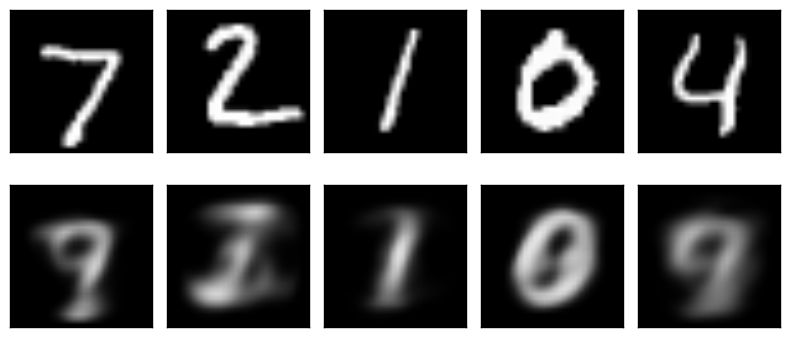

In [11]:
predictions3 = AE3.predict(X_test)
draw_predictions_set(predictions3, 'NB2-MLP-AE3')

In [12]:
# A deeper autoencoder

num_latent_vars = 20

AE4 = Sequential()
AE4.add(Dense(512, input_dim=pixels_per_image, activation='relu'))
AE4.add(Dense(256, activation='relu'))
AE4.add(Dense(num_latent_vars, activation='relu'))
AE4.add(Dense(256, activation='relu'))
AE4.add(Dense(512, activation='relu'))
AE4.add(Dense(pixels_per_image, activation='sigmoid'))
AE4.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE4-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE4, weights_filename):
    AE4.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE4, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 0.2895 - val_loss: 0.2331
Epoch 2/50
 - 12s - loss: 0.2099 - val_loss: 0.1924
Epoch 3/50
 - 13s - loss: 0.1807 - val_loss: 0.1697
Epoch 4/50
 - 13s - loss: 0.1648 - val_loss: 0.1592
Epoch 5/50
 - 13s - loss: 0.1531 - val_loss: 0.1466
Epoch 6/50
 - 12s - loss: 0.1445 - val_loss: 0.1390
Epoch 7/50
 - 11s - loss: 0.1371 - val_loss: 0.1306
Epoch 8/50
 - 12s - loss: 0.1312 - val_loss: 0.1254
Epoch 9/50
 - 11s - loss: 0.1264 - val_loss: 0.1221
Epoch 10/50
 - 11s - loss: 0.1228 - val_loss: 0.1191
Epoch 11/50
 - 11s - loss: 0.1197 - val_loss: 0.1169
Epoch 12/50
 - 11s - loss: 0.1169 - val_loss: 0.1124
Epoch 13/50
 - 12s - loss: 0.1146 - val_loss: 0.1112
Epoch 14/50
 - 14s - loss: 0.1128 - val_loss: 0.1113
Epoch 15/50
 - 13s - loss: 0.1112 - val_loss: 0.1111
Epoch 16/50
 - 12s - loss: 0.1095 - val_loss: 0.1073
Epoch 17/50
 - 12s - loss: 0.1084 - val_loss: 0.1084
Epoch 18/50
 - 12s - loss: 0.1070 - val_loss: 0.1037
Epoch

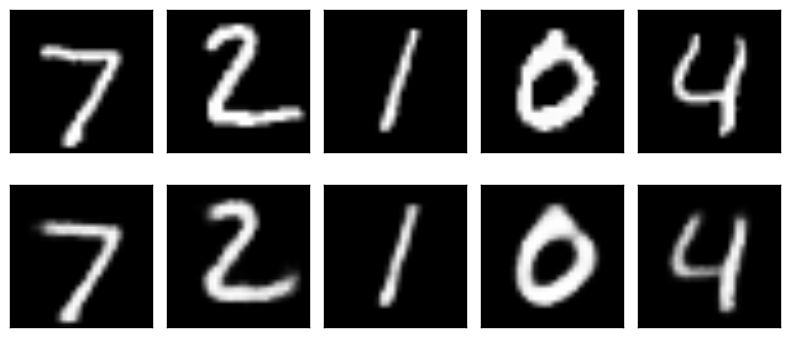

In [13]:
predictions4 = AE4.predict(X_test)
draw_predictions_set(predictions4, 'NB2-MLP-AE4')

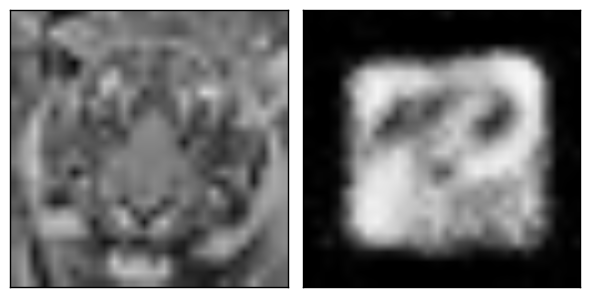

In [15]:
from PIL import Image
filepath = file_helper.get_input_file_path("tiger-gray-28-28.png")
im = Image.open(filepath) #Can be many different formats.
pix = im.load()
tiger = np.zeros((1,784))
for y in range(28):
    for x in range(28):
        tiger[0,(y*28)+x] = pix[x,y][0]/255.
        
predicted_tiger = AE4.predict(tiger)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(predicted_tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB2-MLP-AE4-tiger-pair')
plt.show()

In [16]:
##### Second set of figures for the "Exploring" section

In [17]:
# rebuild AE4 with the Functional API so we can play with the decoder alone
from keras.layers import Input

num_latent_vars = 20

AE5_encoder_input = Input(shape=(784,))
AE5_encoder_512 = Dense(512, activation='relu')
AE5_encoder_256 = Dense(256, activation='relu')
AE5_encoder_latent = Dense(num_latent_vars, activation='relu')

AE5_decoder_256 = Dense(256, activation='relu')
AE5_decoder_512 = Dense(512, activation='relu')
AE5_decoder_out = Dense(784, activation='sigmoid')

AE5_encoder_step_1 = AE5_encoder_512(AE5_encoder_input)
AE5_encoder_step_2 = AE5_encoder_256(AE5_encoder_step_1)
AE5_encoder_output = AE5_encoder_latent(AE5_encoder_step_2)

AE5_decoder_step_1 = AE5_decoder_256(AE5_encoder_output)
AE5_decoder_step_2 = AE5_decoder_512(AE5_decoder_step_1)
AE5_decoder_output = AE5_decoder_out(AE5_decoder_step_2)

AE5 = Model(AE5_encoder_input, AE5_decoder_output)

AE5_encoder_only_model = Model(AE5_encoder_input, AE5_encoder_output)

AE5_decoder_only_input = Input(shape=(num_latent_vars,))
AE5_decoder_only_step_1 = AE5_decoder_256(AE5_decoder_only_input)
AE5_decoder_only_step_2 = AE5_decoder_512(AE5_decoder_only_step_1)
AE5_decoder_only_output = AE5_decoder_out(AE5_decoder_only_step_2)
AE5_decoder_only_model = Model(AE5_decoder_only_input, AE5_decoder_only_output)

In [18]:
AE5.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE5-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE5, weights_filename):
    AE5.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE5, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 13s - loss: 0.2895 - val_loss: 0.2335
Epoch 2/50
 - 12s - loss: 0.2100 - val_loss: 0.1896
Epoch 3/50
 - 12s - loss: 0.1806 - val_loss: 0.1696
Epoch 4/50
 - 12s - loss: 0.1642 - val_loss: 0.1573
Epoch 5/50
 - 11s - loss: 0.1528 - val_loss: 0.1454
Epoch 6/50
 - 12s - loss: 0.1442 - val_loss: 0.1390
Epoch 7/50
 - 12s - loss: 0.1369 - val_loss: 0.1298
Epoch 8/50
 - 12s - loss: 0.1309 - val_loss: 0.1258
Epoch 9/50
 - 13s - loss: 0.1263 - val_loss: 0.1225
Epoch 10/50
 - 14s - loss: 0.1225 - val_loss: 0.1191
Epoch 11/50
 - 14s - loss: 0.1194 - val_loss: 0.1160
Epoch 12/50
 - 11s - loss: 0.1167 - val_loss: 0.1154
Epoch 13/50
 - 11s - loss: 0.1143 - val_loss: 0.1127
Epoch 14/50
 - 11s - loss: 0.1125 - val_loss: 0.1100
Epoch 15/50
 - 11s - loss: 0.1110 - val_loss: 0.1102
Epoch 16/50
 - 11s - loss: 0.1094 - val_loss: 0.1073
Epoch 17/50
 - 11s - loss: 0.1079 - val_loss: 0.1056
Epoch 18/50
 - 11s - loss: 0.1069 - val_loss: 0.1041
Epoch

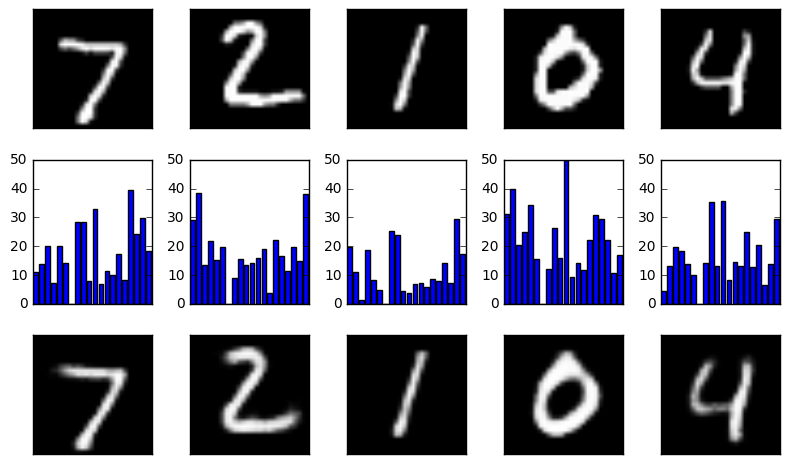

In [19]:
# show the input data, its latent values, and the corresponding predicted images
np.random.seed(random_seed)
encoder_predictions = AE5_encoder_only_model.predict(X_test)

plt.figure(figsize=(8, 5))
latent_min = np.min(encoder_predictions[0:5])
latent_max = np.max(encoder_predictions[0:5])
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.bar(np.arange(len(encoder_predictions[i])), encoder_predictions[i])
    plt.xticks([], [])
    plt.ylim(latent_min, latent_max)
    
    plt.subplot(3, 5, i+11)
    decoder_model_input = np.resize(encoder_predictions[i], (1, len(encoder_predictions[i])))
    decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
    plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-latents-and-output")
plt.show()

In [20]:
# show the latent values and the corresponding predicted images
# this makes big vertical spaces between the 
def show_latents_and_predictions(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    latent_min = np.min(predictions[0:5])
    latent_max = np.max(predictions[0:5])
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.bar(np.arange(len(predictions[i])), predictions[i])
        plt.xticks([], [])
        plt.ylim(latent_min, latent_max)

        plt.subplot(2, 5, i+6)
        decoder_model_input = np.resize(predictions[i], (1, len(predictions[i])))
        decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
        plt.imshow(decoder_prediction.reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

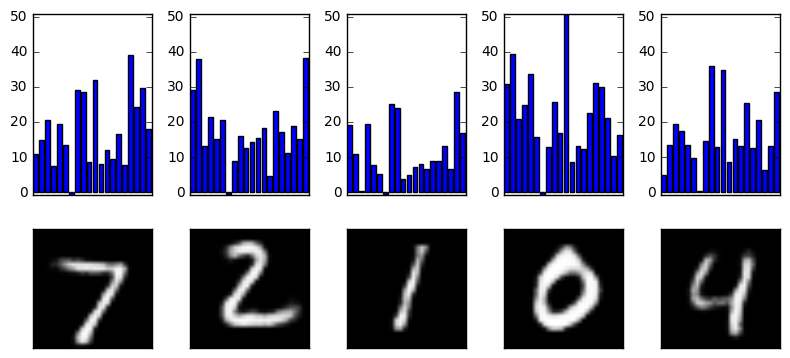

In [21]:
# add [-1,1] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 1
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-1')

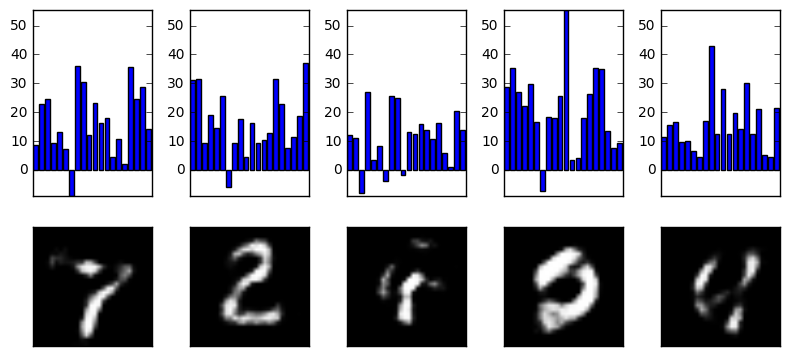

In [22]:
# add [-10,10] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 10
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-10')

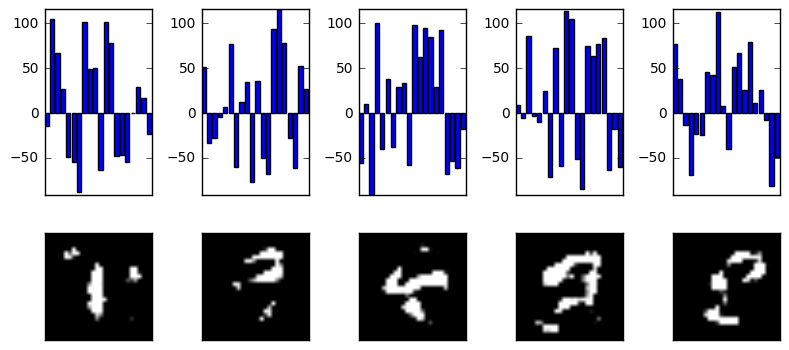

In [23]:
# add [-100,100] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 100
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-100')

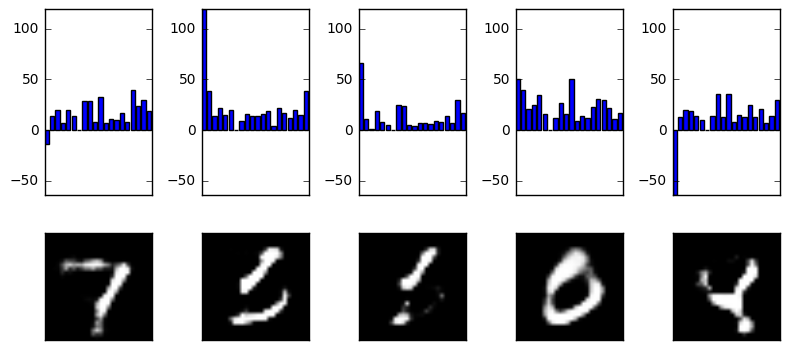

In [24]:
# add [-100,100] noise to just first index
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 100
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i][0] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-100-just-index-0')

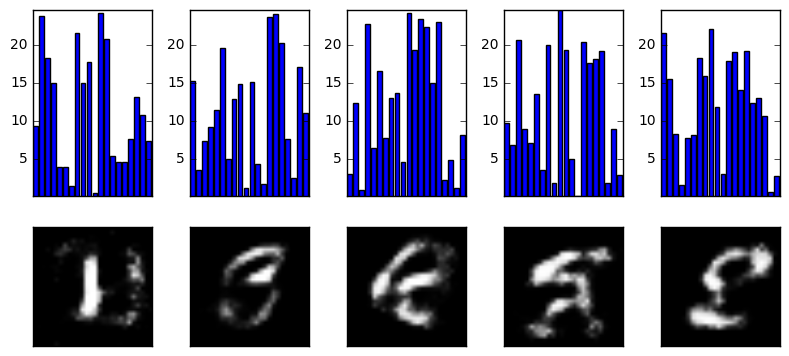

In [25]:
# all latent values are noise
encoder_predictions = np.zeros((5,20))
np.random.seed(random_seed)
noise = 10
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i] = np.random.uniform(low=0, high=25, size = len(encoder_predictions[i]))
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-just-noise')

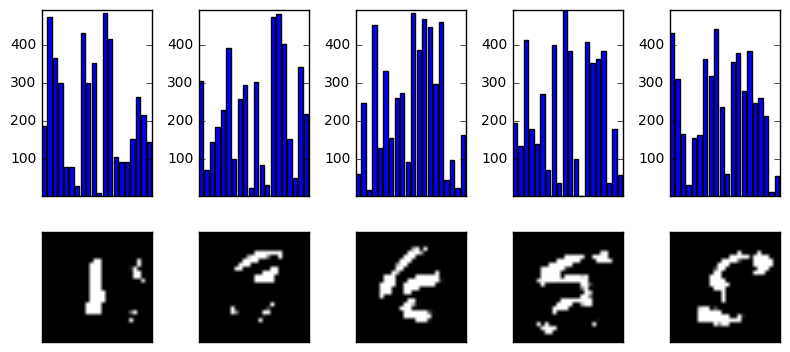

In [26]:
# all latent values are noise
encoder_predictions = np.zeros((5,20))
np.random.seed(random_seed)
noise = 500
for i in range(encoder_predictions.shape[0]):
    encoder_predictions[i] = np.random.uniform(low=0, high=noise, size = len(encoder_predictions[i]))
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-just-noise-500')

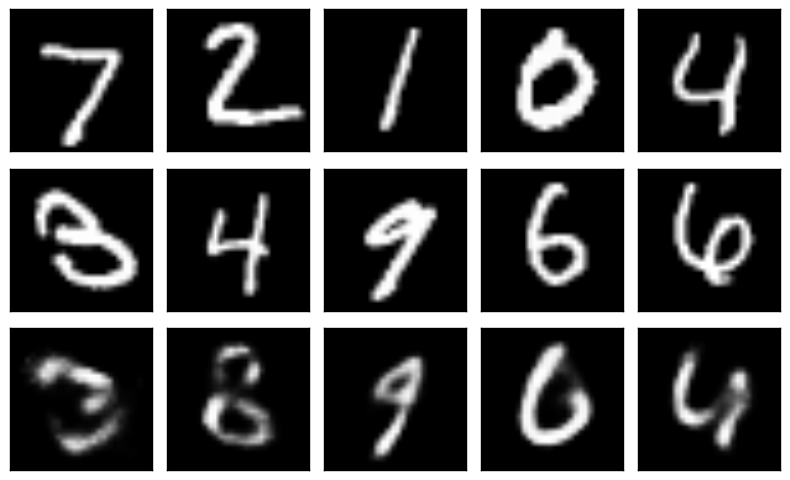

In [27]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

plt.figure(figsize=(8, 5))
offset = 18
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+11)
    latent0 = encoder_predictions[i]
    latent1 = encoder_predictions[i+offset]
    latent_mix = [(latent0[i]+latent1[i])/2. for i in range(len(latent0))]
    latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
    decoder_prediction = AE5_decoder_only_model.predict(latent_mix)
    plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-blend-grid")
plt.show()

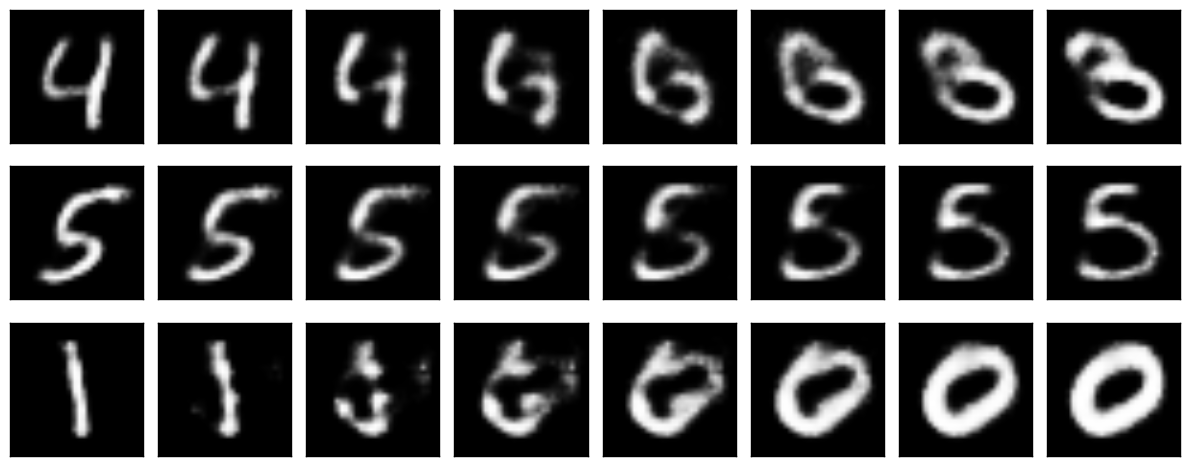

In [28]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
latent0_list = [ encoder_predictions[4], encoder_predictions[23], encoder_predictions[29]]
latent1_list = [ encoder_predictions[18], encoder_predictions[15], encoder_predictions[25]]

for r in range(3):
    latent0 = latent0_list[r]
    latent1 = latent1_list[r]
    for i in range(steps): 
        plt.subplot(3, steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
        decoder_prediction = AE5_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB2-MLP-AE5-blend-linear")
plt.show()

In [29]:
# make a functional model with 2 latent variables for the scatter plot
from keras.layers import Input

num_latent_vars = 2

AE6_encoder_input = Input(shape=(784,))
AE6_encoder_512 = Dense(512, activation='relu')
AE6_encoder_256 = Dense(256, activation='relu')
AE6_encoder_latent = Dense(num_latent_vars, activation='relu')

AE6_decoder_256 = Dense(256, activation='relu')
AE6_decoder_512 = Dense(512, activation='relu')
AE6_decoder_out = Dense(784, activation='sigmoid')

AE6_encoder_step_1 = AE6_encoder_512(AE6_encoder_input)
AE6_encoder_step_2 = AE6_encoder_256(AE6_encoder_step_1)
AE6_encoder_output = AE6_encoder_latent(AE6_encoder_step_2)

AE6_decoder_step_1 = AE6_decoder_256(AE6_encoder_output)
AE6_decoder_step_2 = AE6_decoder_512(AE6_decoder_step_1)
AE6_decoder_output = AE6_decoder_out(AE6_decoder_step_2)

AE6 = Model(AE6_encoder_input, AE6_decoder_output)

AE6_encoder_only_model = Model(AE6_encoder_input, AE6_encoder_output)

AE6_decoder_only_input = Input(shape=(num_latent_vars,))
AE6_decoder_only_step_1 = AE6_decoder_256(AE6_decoder_only_input)
AE6_decoder_only_step_2 = AE6_decoder_512(AE6_decoder_only_step_1)
AE6_decoder_only_output = AE6_decoder_out(AE6_decoder_only_step_2)
AE6_decoder_only_model = Model(AE6_decoder_only_input, AE6_decoder_only_output)

AE6.compile(optimizer='adadelta', loss='binary_crossentropy')

weights_filename = "NB2-AE6-weights"
np.random.seed(42)
if not file_helper.load_model_weights(AE6, weights_filename):
    AE6.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(AE6, weights_filename)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 12s - loss: 0.3326 - val_loss: 0.2559
Epoch 2/50
 - 11s - loss: 0.2528 - val_loss: 0.2519
Epoch 3/50
 - 11s - loss: 0.2503 - val_loss: 0.2497
Epoch 4/50
 - 11s - loss: 0.2481 - val_loss: 0.2461
Epoch 5/50
 - 11s - loss: 0.2453 - val_loss: 0.2437
Epoch 6/50
 - 11s - loss: 0.2434 - val_loss: 0.2420
Epoch 7/50
 - 11s - loss: 0.2421 - val_loss: 0.2413
Epoch 8/50
 - 11s - loss: 0.2412 - val_loss: 0.2403
Epoch 9/50
 - 11s - loss: 0.2405 - val_loss: 0.2397
Epoch 10/50
 - 11s - loss: 0.2399 - val_loss: 0.2390
Epoch 11/50
 - 11s - loss: 0.2393 - val_loss: 0.2388
Epoch 12/50
 - 11s - loss: 0.2388 - val_loss: 0.2382
Epoch 13/50
 - 12s - loss: 0.2382 - val_loss: 0.2373
Epoch 14/50
 - 11s - loss: 0.2353 - val_loss: 0.2303
Epoch 15/50
 - 11s - loss: 0.2266 - val_loss: 0.2226
Epoch 16/50
 - 11s - loss: 0.2220 - val_loss: 0.2189
Epoch 17/50
 - 12s - loss: 0.2188 - val_loss: 0.2163
Epoch 18/50
 - 11s - loss: 0.2164 - val_loss: 0.2144
Epoch

In [30]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
  
# scatter plot from AE6
def draw_scatter(diameter, limits=None, filename=None):
    encoder_predictions = np.array(AE6_encoder_only_model.predict(X_test))
    np.random.seed(random_seed)

    plt.clf()
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, aspect='equal')

    # display a 2D plot of the digit classes in the latent space
    clrs = [ 'red', 'sandybrown', 'sienna', 'gold', 'palegreen',
            'limegreen', 'deepskyblue', 'blue', 'plum', 'magenta' ]

    for i in range(len(encoder_predictions)):
        p = patches.Circle(encoder_predictions[i], diameter,
                            edgecolor='black', facecolor=clrs[y_test[i]])
        ax.add_patch(p)

    handle_list = []
    for i in range(10):
        p = patches.Patch(color=clrs[i], label=str(i))
        handle_list.append(p)
    ax.legend(handles=handle_list, loc='upper right', shadow=True)

    if limits:
        (pxmin, pxmax, pymin, pymax) = limits
    else:
        xmin = np.min(encoder_predictions[:,0])
        xmax = np.max(encoder_predictions[:,0])
        pxmin = xmin - (.05 * (xmax-xmin))
        pxmax = xmax + (.15 * (xmax-xmin))
        ymin = np.min(encoder_predictions[:,1])
        ymax = np.max(encoder_predictions[:,1])
        pymin = ymin - (.05 * (ymax-ymin))
        pymax = ymax + (.05 * (ymax-ymin))
    ax.set_ylim([pymin, pymax])
    ax.set_xlim([pxmin, pxmax])

    file_helper.save_figure(filename)

    plt.show()

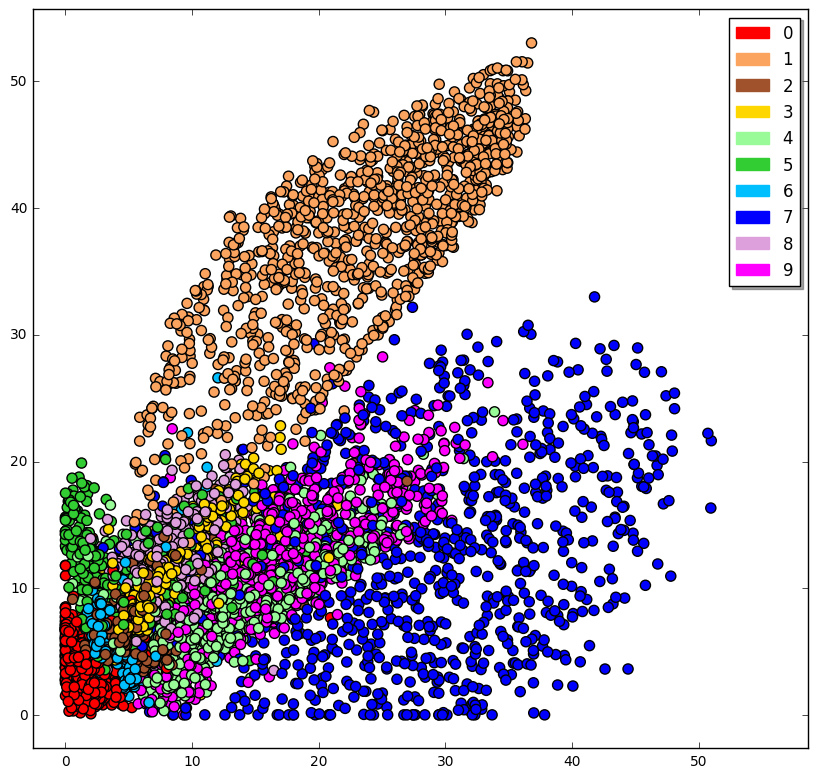

In [31]:
draw_scatter(.4, limits=None, filename='NB2-MLP-AE6-latent-scatter')

In [62]:
def draw_decoder_grid(steps=17, limits=None, filename=None):

    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * steps, digit_size * steps))
    grid_x = np.linspace(limits[1], limits[0], steps)
    grid_y = np.linspace(limits[2], limits[3], steps) 

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            
            latents = np.array([[xi, yi]])
            decoder_prediction = AE6_decoder_only_model.predict(latents)
            
            digit = decoder_prediction[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(figure, cmap='gray')
    file_helper.save_figure(filename)
    plt.show()

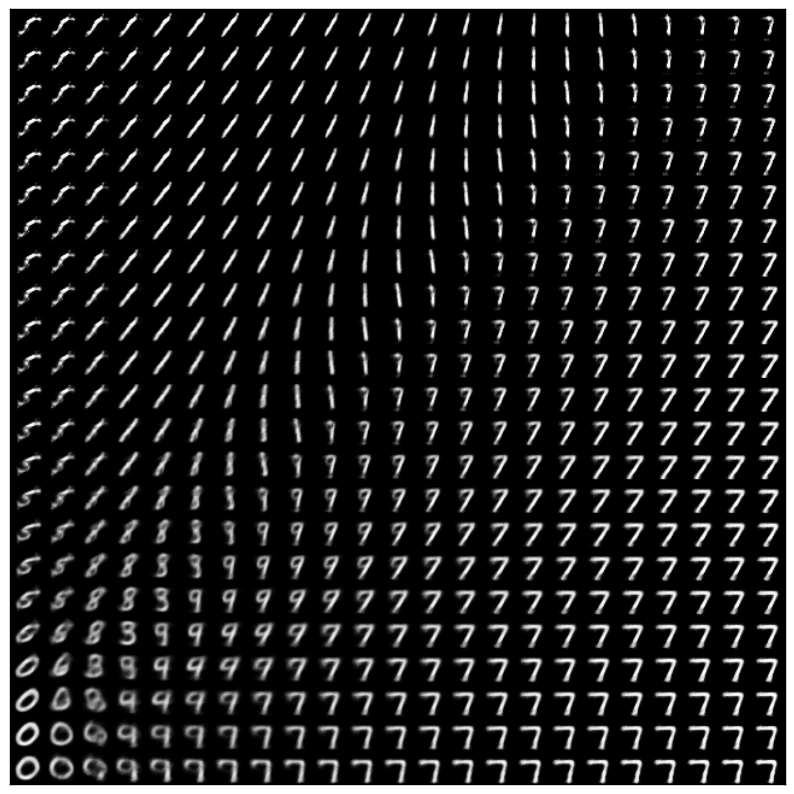

In [63]:
draw_decoder_grid(steps=23, limits=(0, 55, 0, 55), filename='NB2-MLP-AE6-17-decoder-grid')

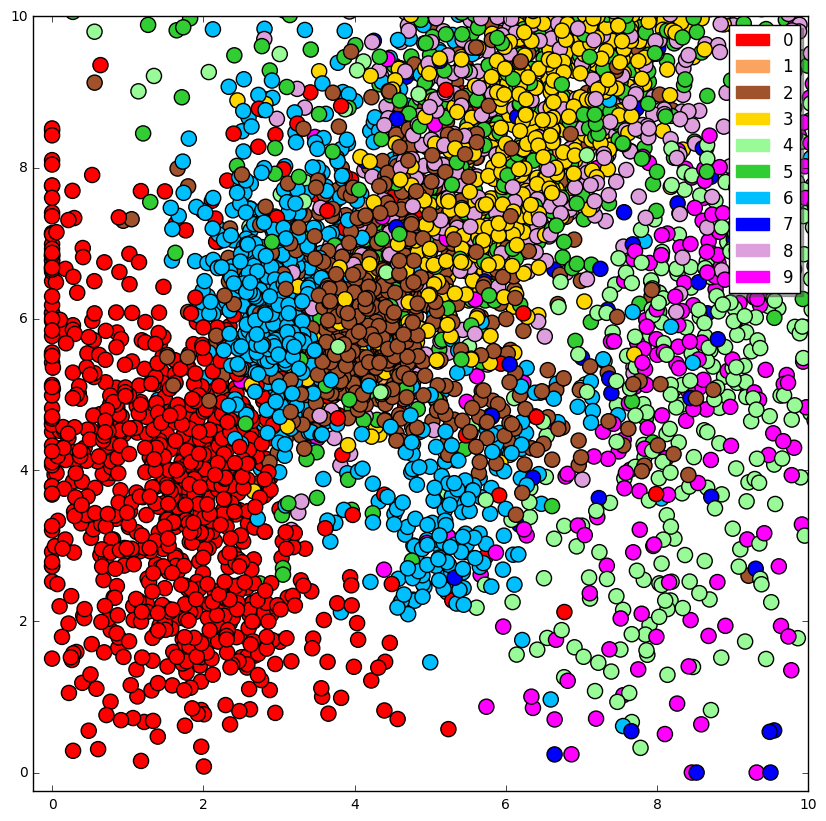

In [32]:
draw_scatter(.1, limits=(-.25, 10, -.25, 10), filename='NB2-MLP-AE6-latent-scatter-cu')

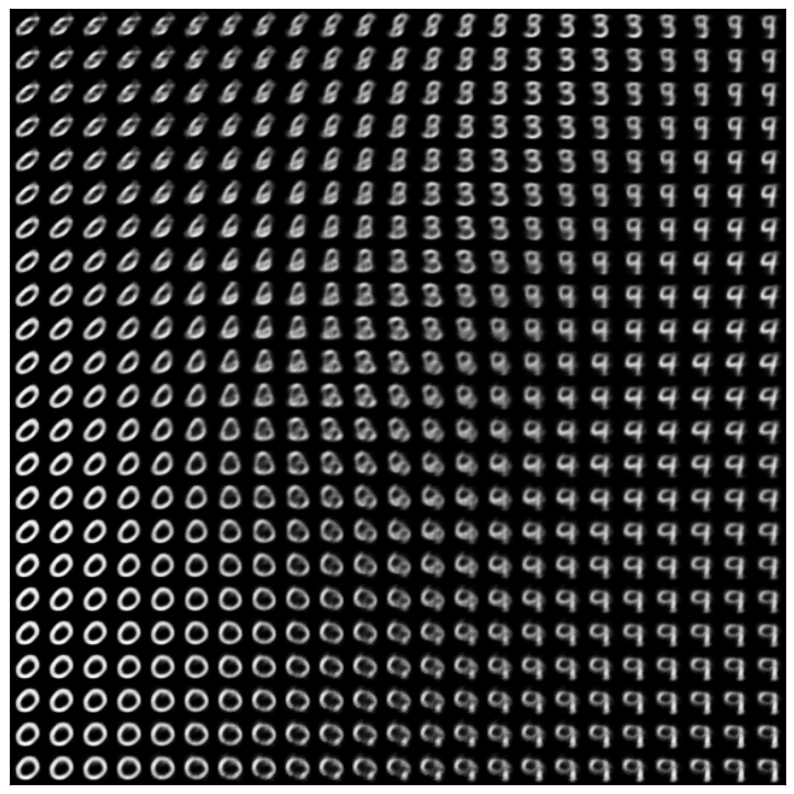

In [64]:
draw_decoder_grid(steps=23, limits=(-.25, 10, -.25, 10), filename='NB2-MLP-AE6-17-decoder-grid-CU')

In [33]:
def show_from_latents(latents_list, filename=None):
    numplots = len(latents_list)
    plt.clf()
    plt.figure(figsize=(4*numplots, 4))
    for i in range(numplots):
        latents = np.array(latents_list[i])
        latent_grid = np.resize(latents, (1,len(latents)))
        decoder_prediction = AE6_decoder_only_model.predict(latent_grid)
        plt.subplot(1, numplots, i+1)
        plt.imshow(np.reshape(decoder_prediction, (28,28)), cmap='gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

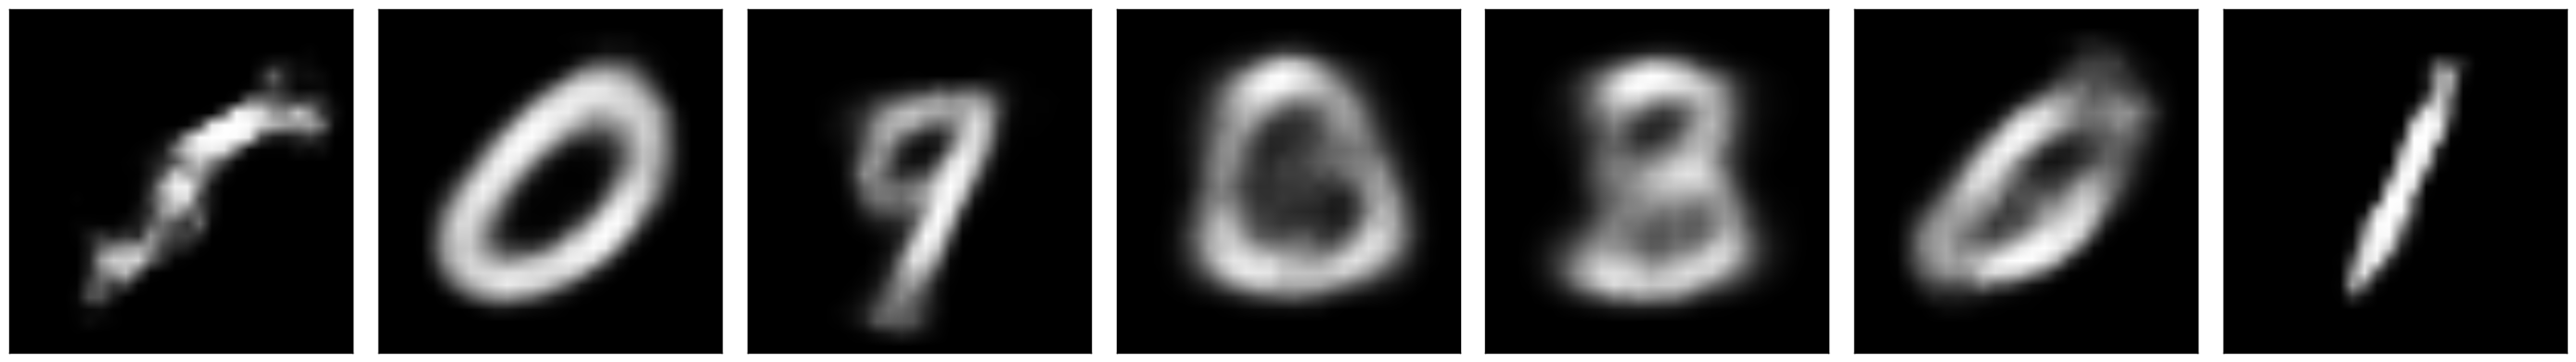

In [34]:
save_figures = True
show_from_latents(
    ((2,30),(.5,5),(23,17),(3,4),(5,7),(1,8),(30,60)),
    #((2,0),(5,2),(4,6),(8,11),(35,55),(33.5,25), (40,13)), 
    'NB2-MLP-AE6-whitespace-predictions')

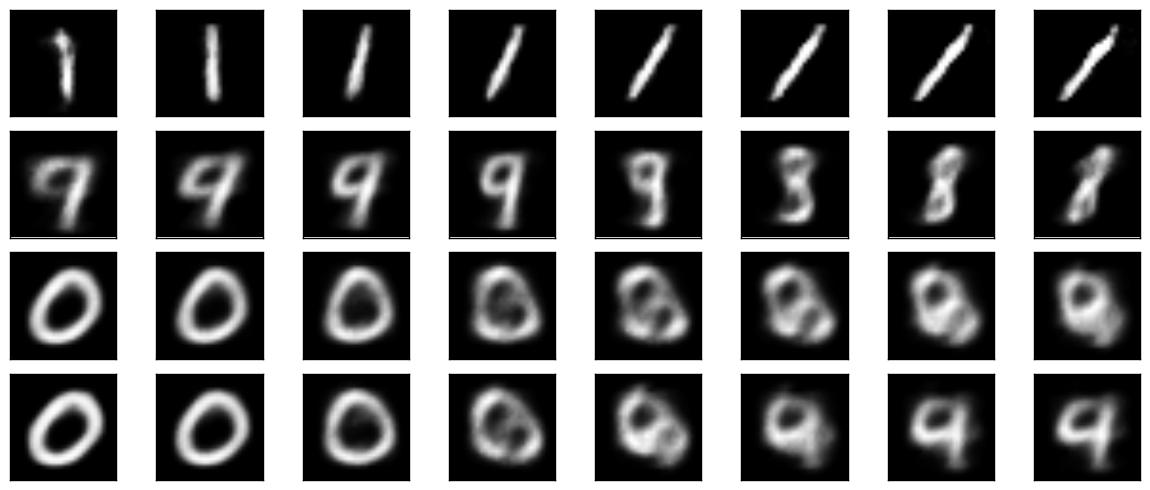

In [35]:
# blend latents for two test images and decompress
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
#latent0_list = [ (5,25), (6,.5), (3,3), (3,3)]
#latent1_list = [ (25, 60) , (30,5), (2,6), (30,35)]
latent0_list = [(30,35), (15,5), (1,3), (0,2)]
latent1_list = [(10,55), (10,20), (6,5), (9,5)]

for r in range(len(latent0_list)):
    latent0 = latent0_list[r]
    latent1 = latent1_list[r]
    for i in range(steps): 
        plt.subplot(len(latent0_list), steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1,len(latent_mix)))
        decoder_prediction = AE6_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB2-MLP-AE6-blend-linear-through-scatter')
plt.show()